# Data Retrieval 

In the code cell below, we will first import all relevant packages we will need for our data analyses and visualisations. These include pandas (pd), numpy (np), matplotlib.pyplot (plt), and yfinance (yf). The latter will allow us to download stock price data from Yahoo Finance. 

The last line of code will set the style for all plots created with matplotlib to ggplot. 

In [2]:
#Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

#Set the style for plots
plt.style.use("ggplot")

Next, we will prepare our data frame, which will include the 2020-2024 data for 10 stocks, namely: 
- Amazon (AMZN)
- Tesla (TSLA)
- JPMorgan (JPM)
- Walmart (WMT)
- Visa (V)
- Netflix (NFLX)
- Exxon Mobil (XOM)
- Procter & Gamble (PG)
- Johnson & Johnson (JNJ)
- Coca-Cola (KO)

We will pull the data from Yahoo Finance and save it to a single CSV file. 

In [3]:
#Download data from Yahoo Finance
tickers = ["AMZN", "TSLA", "JPM", "WMT", "V", "NFLX", "XOM", "PG", "JNJ", "KO"]
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

#Create a separate "Ticker" column 
df = data.stack(level=1).reset_index()

#Rearrange so that all tickers of one company are shown before the tickers of the next company
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

#Save to a CSV file 
df.to_csv("portfolio_data.csv", index=False)

#Check date format
print("The date format is: \n", df.Date.head())

#Load the data
df = pd.read_csv("portfolio_data.csv")

#Convert to a datetime object
df["Date"] = pd.to_datetime(df["Date"])

/tmp/ipykernel_136877/2668217325.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  10 of 10 completed
/tmp/ipykernel_136877/2668217325.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack(level=1).reset_index()


The date format is: 
 0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
Name: Date, dtype: datetime64[ns]


# Continue here
# Data Cleaning
Having saved 

In [ ]:
#Check for missing values
print("Missing data", df.isnull().sum().sum())

#Check for ascending order in the index by ticker 
order = df.groupby("Ticker")["Date"].apply(lambda x: x.is_monotonic_increasing)
print("In ascending order:\n", order)

#Continue here
#Check for duplicates
df.duplicated().sum()


Missing data 0
In ascending order:
 Ticker
AMZN    True
JNJ     True
JPM     True
KO      True
NFLX    True
PG      True
TSLA    True
V       True
WMT     True
XOM     True
Name: Date, dtype: bool


and preparing our data frame in the cell below that.

# Trading Strategies

Let's start with a classic and simple trading strategy: the moving average crossover. The idea behind this strategy is to buy a stock when its fast simple moving average (SMA) crosses above its slow SMA and to short it when the fast SMA crosses below the slow SMA.

Let's start with our imports in the cell below, and preparing our data frame in the cell below that.

This time we'll fetch our data directly from yfinance.

In [5]:


df = yf.download("JPM",start="2025-01-01")
df

df.columns = df.columns.droplevel(1) # To get rid of the Multi index
df
## The manual way
# df = pd.read_csv("data/JPM_data.csv")
# df["Date"] = pd.to_datetime(df["Date"])
# df = df.set_index("Date").sort_index().drop_duplicates()


/tmp/ipykernel_136877/3131148974.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("JPM",start="2025-01-01")


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,237.305176,240.548345,236.761348,238.214844,9220900
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300
...,...,...,...,...,...
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600


## Compute and Plot SMAs

Before we can implement our strategy, we need to calculate the fast (short-term) and slow (long-term) SMAs. For this example, we'll use 20-day and 50-day SMAs.

In [6]:
fast = 5
slow = 10

df["FastSMA"] = df.Close.rolling(window=fast).mean()
df["SlowSMA"] = df.Close.rolling(window=slow).mean()
df

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA
Date,,,,,,,
2025-01-02,237.305176,240.548345,236.761348,238.214844,9220900,NaN,NaN
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110406,NaN
...,...,...,...,...,...,...,...
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400,269.405994,267.819998
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700,270.757996,269.124997
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600,273.421991,270.378995



Remember we'll have a window-length of NaNs in our data frame. This is because we don't have enough data points to calculate an N-day moving average until the Nth day. 
Let's plot the closing price with the SMAs to visually inspect the crossover points.

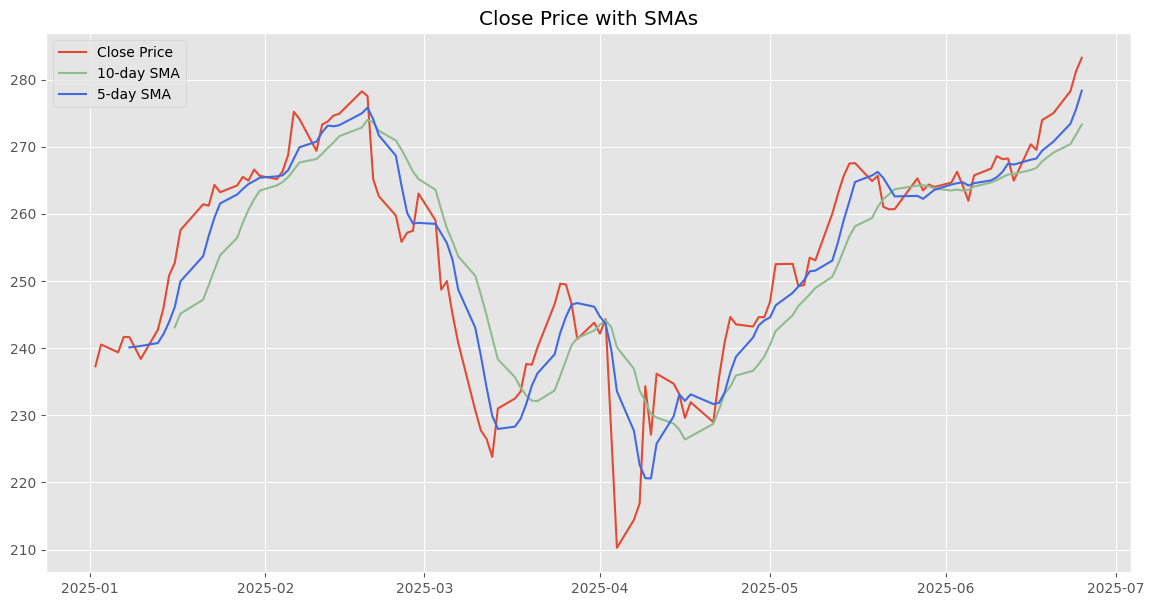

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(df.Close, label='Close Price')

# There are some ideas about colours of lines
# eye-catching for the fast, and more mellow for the slow
plt.plot(df.SlowSMA, label=f"{slow}-day SMA", color="darkseagreen")
plt.plot(df.FastSMA, label=f"{fast}-day SMA", color="royalblue")
plt.legend()
plt.title('Close Price with SMAs')
plt.show()

## The Crossover

To determine the crossover points, we will create a new column signal which will contain 1 for buy signals (when the fast SMA is above the slow SMA) and -1 for sell signals. Because we are in a *wait* position while we *wait* for the 200-day SMA to kick-in, we'll fill the Signal column with 0 for those rows. We'll use `where()` for both of these.

In [8]:
# np.where() is great to generate signals based on the position of the lines
df["Signal"] = np.where(df.FastSMA > df.SlowSMA, 1, -1)
df.Signal = np.where(df.SlowSMA.isna(), 0, df.Signal)
df

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA,Signal
Date,,,,,,,,
2025-01-02,237.305176,240.548345,236.761348,238.214844,9220900,NaN,NaN,0
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN,0
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN,0
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN,0
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110406,NaN,0
...,...,...,...,...,...,...,...,...
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400,269.405994,267.819998,1
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700,270.757996,269.124997,1
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600,273.421991,270.378995,1


### Exercise: Blink and you'll miss it

Can you identify on which dates we had a crossover?

In [9]:
## YOUR CODE GOES HERE

## Backtesting

Backtesting is the process of testing a trading strategy on relevant historical data. We can calculate how it would have performed, had it been applied in the past. The simplest backtest calculates the returns that would have been realised if the strategy was implemented.

First, we create a new column with the signal from the previous day. When we backtest, we have to imagine we're trading in real time. Since our signals are based on close prices, we won't be able to act on them until the following day when the market re-opens. Failing to do this is called *look-ahead bias*.

In [10]:
# Take a look at the day we generated the buy signal
# When could we have acted on it?
print(df.loc["2020-10-16":"2020-10-21"])

# Shift down to avoid look-ahead bias
df['Position'] = df.Signal.shift(1)
df

Empty DataFrame
Columns: [Close, High, Low, Open, Volume, FastSMA, SlowSMA, Signal]
Index: []


Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA,Signal,Position
Date,,,,,,,,,
2025-01-02,237.305176,240.548345,236.761348,238.214844,9220900,NaN,NaN,0,NaN
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN,0,0.0
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN,0,0.0
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN,0,0.0
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110406,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400,269.405994,267.819998,1,1.0
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700,270.757996,269.124997,1,1.0
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600,273.421991,270.378995,1,1.0


Next we calculate the market daily returns normally using `pct_change()`. We then calculate our strategy returns by multiplying our buy/sell position with the market returns. Here is how it works:

- On days when the market gains (+ market return)
    - In the buy position (+) , our strategy gains
    - In the sell position (-), our strategy loses
- On days when the market loses (- market return)
    - In the buy position (+), our strategy loses
    - In the sell position (-), our strategy gains

In [11]:
# Calculating the daily market return (or a buy and hold strategy)
df["MarketDaily"] = df.Close.pct_change()

# Calculating the daily return of our crossover strategy
df["StrategyDaily"] = df.Position * df.MarketDaily

df

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA,Signal,Position,MarketDaily,StrategyDaily
Date,,,,,,,,,,,
2025-01-02,237.305176,240.548345,236.761348,238.214844,9220900,NaN,NaN,0,NaN,NaN,NaN
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN,0,0.0,0.013667,0.000000
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN,0,0.0,-0.004875,-0.000000
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN,0,0.0,0.009633,0.000000
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110406,NaN,0,0.0,-0.000164,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400,269.405994,267.819998,1,1.0,0.016474,0.016474
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700,270.757996,269.124997,1,1.0,0.003796,0.003796
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600,273.421991,270.378995,1,1.0,0.011891,0.011891


To determine if our strategy would profit or lose, we can calculate the cumulative returns of our strategy for the period. We can then compare it to a *buy & hold* strategy (where we buy at the start of the period and sell at the end), which is represented as the cumulative market returns.

In [12]:
df["MarketReturn"] = (1 + df.MarketDaily).cumprod() - 1
df["StrategyReturn"] = (1 + df.StrategyDaily).cumprod() - 1

df.tail()

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA,Signal,Position,MarketDaily,StrategyDaily,MarketReturn,StrategyReturn
Date,,,,,,,,,,,,,
2025-06-18,273.959991,277.720001,269.720001,270.000000,9586400,269.405994,267.819998,1,1.0,0.016474,0.016474,0.154463,0.355463
2025-06-20,275.000000,277.299988,273.809998,275.570007,13969700,270.757996,269.124997,1,1.0,0.003796,0.003796,0.158845,0.360609
2025-06-23,278.269989,278.549988,272.109985,275.059998,8094600,273.421991,270.378995,1,1.0,0.011891,0.011891,0.172625,0.376787
2025-06-24,281.260010,282.709991,279.510010,280.209991,9266700,275.601996,271.830997,1,1.0,0.010745,0.010745,0.185225,0.391581
2025-06-25,283.239594,283.309998,280.910004,281.500000,2701298,278.345917,273.294955,1,1.0,0.007038,0.007038,0.193567,0.401375


Let's plot these for a visual representation.

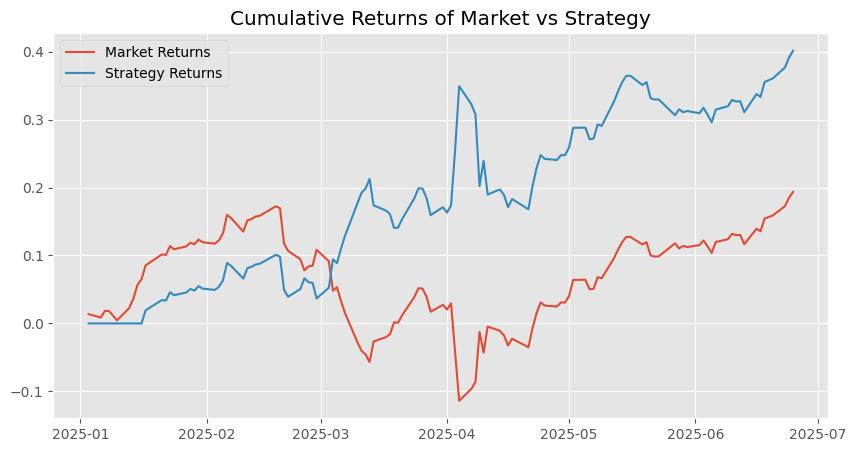

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(df.MarketReturn, label="Market Returns")
plt.plot(df.StrategyReturn, label="Strategy Returns")
plt.legend()
plt.title("Cumulative Returns of Market vs Strategy")
plt.show()